## Training model

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install tensorflow --upgrade
import tensorflow as tf
tf.keras.backend.clear_session()

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:67> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-c9d8a55c8046>", line 33, in <cell line: 33>
    uvicorn.run(app, port=8000)
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/main.py", line 577, in run
    server.run()
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/u

In [34]:
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate=rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        super(TransformerBlock, self).__init__(**kwargs)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {"embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "rate": self.rate }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, ** kwargs):
        self.maxlen=maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {"maxlen": self.maxlen, "vocab_size": self.vocab_size, "embed_dim": self.embed_dim }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [35]:
df = pd.read_csv("/content/drive/MyDrive/LLM/combined_data.csv")

df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [36]:
#thống kê
df.groupby('label').describe()

text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538  subscribe change profile contact us long term ...    1
1      43910  43910  get the most out of life ! viagra has helped m...    1

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(75103,) (8345,) (75103,) (8345,)


In [38]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

from tensorflow.keras.preprocessing import text
import pickle

# Create a tokenizer
tokenizer = text.Tokenizer(num_words=vocab_size)


# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Save the tokenizer to a file
with open('/content/drive/MyDrive/LLM/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert the training data to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [40]:
inputs = layers.Input(shape=(maxlen,), )
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657,758 (2.51 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
X_train

array([[  29,  120,  749, ...,  451,   30, 5247],
       [   0,    0,    0, ...,  237,  277,  123],
       [   0,    0,    0, ...,    1,    1,    1],
       ...,
       [   1,    1,  573, ...,  237,  277,  123],
       [   0,    0,    0, ...,  114,   99, 7699],
       [7841, 2200,    4, ..., 1920,   21, 4965]], dtype=int32)

In [42]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=15
)

Epoch 1/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.9354 - loss: 0.1546
Epoch 2/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9942 - loss: 0.0211
Epoch 3/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9965 - loss: 0.0124
Epoch 4/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9980 - loss: 0.0077
Epoch 5/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9983 - loss: 0.0065
Epoch 6/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9988 - loss: 0.0042
Epoch 7/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9989 - loss: 0.0034
Epoch 8/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9993 - loss: 0.0031
Epoch 9/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 10/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9995 - loss: 0.0020
Epoch 11/15
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 12/15
2347/23

In [43]:
model.evaluate(X_test, y_test)

261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9865 - loss: 0.0806


[0.08355936408042908, 0.9859796166419983]

In [48]:
email = ["Hello can you remind me tomorrow?"]
email = tokenizer.texts_to_sequences(email)
email = keras.preprocessing.sequence.pad_sequences(email, maxlen=maxlen)
model.predict(email)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[9.9999893e-01, 1.0230542e-06]], dtype=float32)

In [51]:
with open('/content/drive/MyDrive/LLM/tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)
    email = ["Hello can you remind me tomorrow?"]
    email = tokenizer2.texts_to_sequences(email)
    email = keras.preprocessing.sequence.pad_sequences(email, maxlen=maxlen)
    result = model.predict(email)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[9.9999893e-01 1.0230542e-06]]


261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Confusion Matrix: 


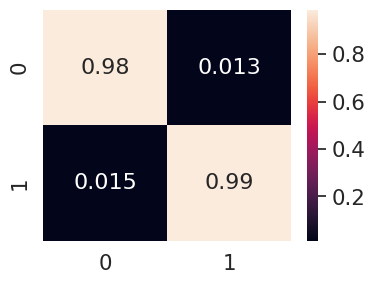

------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3970
           1       0.99      0.99      0.99      4375

    accuracy                           0.99      8345
   macro avg       0.99      0.99      0.99      8345
weighted avg       0.99      0.99      0.99      8345



In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)

result = confusion_matrix(y_test, y_prediction , normalize='pred')
print("Confusion Matrix: ")
df_cm = pd.DataFrame(result)
plt.figure(figsize=(4,3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print("------------------------------------------------------")
print("Classification Report: ")
print(classification_report(y_test, y_prediction))

In [53]:
model.save("/content/drive/MyDrive/LLM/model.keras")

In [ ]:
# Stop here
1/0

## Serve model

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow --upgrade
!pip install fastapi
!pip install uvicorn
!pip install pickle5
!pip install pydantic
!pip install scikit-learn
!pip install requests
!pip install pypi-json
!pip install pyngrok
!pip install nest-asyncio

from fastapi import FastAPI
from pydantic import BaseModel
import pickle
import json
import uvicorn
from pyngrok import ngrok
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [55]:
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate=rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        super(TransformerBlock, self).__init__(**kwargs)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {"embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "rate": self.rate }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, ** kwargs):
        self.maxlen=maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {"maxlen": self.maxlen, "vocab_size": self.vocab_size, "embed_dim": self.embed_dim }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [56]:
custom_objects={'TokenAndPositionEmbedding': TokenAndPositionEmbedding, 'TransformerBlock': TransformerBlock}

loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/LLM/model.keras", custom_objects)
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'token_and_position_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,973,276 (7.53 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,315,518 (5.02 MB)

In [57]:
df = pd.read_csv("/content/drive/MyDrive/LLM/combined_data.csv")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

from tensorflow.keras.preprocessing import text

# Create a tokenizer
tokenizer = text.Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

def predict(email):
  email = tokenizer.texts_to_sequences([email])
  email = keras.preprocessing.sequence.pad_sequences(email, maxlen=maxlen)
  result = loaded_model.predict(email)
  print(result)
  spam_prob = result[0][1]
  ham_prob = result[0][0]
  if spam_prob > 0.5:
    return {"result": "Spam", "percentile": spam_prob*100}
  return {"result": "Ham", "percentile": ham_prob*100}

In [58]:
def predict2(email):
  with open('/content/drive/MyDrive/LLM/tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)
    email = tokenizer2.texts_to_sequences([email])
    email = keras.preprocessing.sequence.pad_sequences(email, maxlen=maxlen)
    result = loaded_model.predict(email)
    print(result)
    spam_prob = result[0][1]
    ham_prob = result[0][0]
    if spam_prob > 0.5:
      return {"result": "Spam", "percentile": spam_prob*100}
    return {"result": "Ham", "percentile": ham_prob*100}

In [59]:
predict("Hello can you remind me tomorrow?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
[[9.9999893e-01 1.0230542e-06]]


{'result': 'Ham', 'percentile': 99.9998927116394}

In [60]:
predict2("Hello can you remind me tomorrow?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[9.9999893e-01 1.0230542e-06]]


{'result': 'Ham', 'percentile': 99.9998927116394}

In [61]:
predict("Hello can you remind me tomorrow?")
predict("Good morning")
predict("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...")
predict("Claim your promotion in order not to miss the chance")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[9.9999893e-01 1.0230542e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9790292  0.02097081]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[9.2202376e-05 9.9990773e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1.2002449e-04 9.9987996e-01]]


{'result': 'Spam', 'percentile': 99.98799562454224}

In [ ]:
from typing import Dict

app = FastAPI()
origins = ["*"]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.get('/')
def home():
    return 'Hello world!'

@app.post('/predict')
def spam_predict(input: Dict[str, str]):
    result = {};
    for key in input.keys():
        result[key] = predict(input[key]);

    print(result)
    return result


from pyngrok import conf, ngrok
!ngrok authtoken 2hrVH5tDzhwfh1LtEtXvwUtmrwG_23D5dF8db5nm4gvBZGruj
ngrok_tunnel = ngrok.connect(8000)
ngrokURL = ngrok_tunnel.public_url
print('Public URL:', ngrokURL)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: https://5d04-34-124-159-115.ngrok-free.app


INFO:     Started server process [188]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     14.161.7.63:0 - "OPTIONS / HTTP/1.1" 200 OK
INFO:     14.161.7.63:0 - "OPTIONS /predict HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.03564254 0.96435744]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.00166993 0.99833006]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9138339  0.08616604]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9635951  0.03640495]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.02739799 0.972602  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[6.8298343e-04 9.9931705e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.00382346 0.9961765 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[6.0517537e-05 9.9993944e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[9.9999738e-01 2.5923364e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[7.6144505e-07 9.9999928e-01]]
{'email': {'result': 'Spam', 'percentile': 96.43574357032776}, 'email1': {'result': 'Spam', 'percentile': 99.83300566673279}, 'email2': {'result': 'Ham', 'percentile': 91.38339161872864}, 'email3': {'result': 'Ham', 'perc

In [ ]:
!pkill uvicorn
!pkill ngrok

In [ ]:
# Stop here
1/0